In [2]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from scipy.linalg import orth
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# Device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
dtype = torch.cuda.FloatTensor

Generate_data

In [3]:

def generate_data(R,n,d,big_sigma_squared,sigma_z,N):
    c=np.random.normal(loc=0, scale=1.0, size=[d,N])
    z=np.random.normal(loc=0, scale=sigma_z, size=[n,N])
    U=orth(np.random.normal(loc=0, scale=1, size=[n,d]))
    L=np.random.choice([-1,1],N)
    L=L.reshape(L.shape[0],1)     
    if R==None:
        R=1

    mu=R*U[:,0]
    mu=mu.reshape(mu.shape[0],1)
                
    U=U@big_sigma_squared
    X=U@c+mu@L.T 
    Y=X+z

    U = torch.from_numpy(U).type(dtype)
    X = torch.from_numpy(X).type(dtype)
    Y = torch.from_numpy(Y).type(dtype)
    L = torch.from_numpy(L).type(dtype)
    mu = torch.from_numpy(mu).type(dtype)
    
    return X,Y,U,L,mu

Compute the risk for a given estimator W subspace u and noise statistics sigma_z.

In [4]:
def test_risk(n,d,W,U,sigma_z,mu):    
    risk = torch.linalg.norm( (W - torch.eye(n).type(dtype)) @ U ,'fro')**2 + sigma_z**2 * torch.linalg.norm(W,'fro')**2+ torch.linalg.norm( (W- torch.eye(n).type(dtype)) @ mu )**2
    # 
    return risk/d

An estimator based on subspace estimation.

In [5]:
def pca_subspace(Y,d,sigma_z):
    U_,S,V = np.linalg.svd(np.dot(Y,Y.T))
    U = U_[:,:d]        
    W = 1/(1+sigma_z**2)* np.dot(U,U.T)         
    return W

Estimator learned end-to-end $W^\infty$

In [21]:
def gradient_descent_converged(X,Y):
    W=X@torch.pinverse(Y)
    return W

Estimator learned end-to-end ridge regression $W^\infty$

In [71]:
def gradient_descent_ridge_converged(X,Y,n,d,U,sigma_z,mu,lamb= torch.linspace(0,1,100)):    
    if X.shape[1]>=5:
        if np.size(lamb)==1:
            l=lamb
            W=X@Y.T@(torch.pinverse(Y@Y.T+l*torch.eye(Y.shape[0]).cuda()))
        else:            
            val_risk=[[] for i in range(len(lamb))]
            for i,l in enumerate(lamb):
                l=l.cuda()
                W=X@Y.T@(torch.pinverse(Y@Y.T+l*torch.eye(Y.shape[0]).cuda()))
                tel=test_risk(n,d,W,U,sigma_z,mu)
                val_risk[i]=tel.item()
            l=lamb[np.argmin(val_risk)]
            W=X@Y.T@(torch.pinverse(Y@Y.T+l*torch.eye(Y.shape[0]).cuda()))
    else:
        W=gradient_descent_converged(X,Y)    
    return W

Estimator learned end-to-end $W^k$

In [8]:
def gradient_descent(W,X,Y,lr):
    dW = W @ Y @ Y.T - X @ Y.T
    W -= lr*dW
    return W

def gradient_descent_train(n,d,N,X, Y, U, sigma_z, num_iters=1000, lr = 1e-2):
        trainL_emp = []
        testL = []



        early_stopping_counter = 0
        early_stopping_loss = 10000
        W = torch.zeros([n,n]).type(dtype)
        for i in range(num_iters):
            if i % 100 == 0:
                print('Iteration : {}/{}'.format(i,num_iters))
            ### train
            # compute the gradient and update the weights
            W = gradient_descent(W,X,Y,lr)           
            
            # train loss
            Xhat = W @ Y
            trl =  ( (Xhat-X)**2 ).sum()/(N*d)
            trainL_emp.append(trl.item())

            ### test
            tel =  test_risk(n,d,W,U,sigma_z,mu)
            testL.append(tel.item())
            
            # Stop if train loss is not improving anymore
            if i>100 and np.abs(trainL_emp[-1]-trainL_emp[-2]) < 1e-20:
                print('Stopped at iteration {} due to convergence'.format(i))
                break
            
            
            # Early stopp 100 iterations after the test loss reached its minimum
            if testL[-1] < early_stopping_loss:
                early_stopping_loss = testL[-1]
            else:
                early_stopping_counter += 1
            if early_stopping_counter == 100:
                print('Stopped at iteration {} due to early stopping'.format(i))
                break
            
        return testL, trainL_emp

The optimal linear estimator $W^\star$

In [14]:
def W_star(U,sigma_z):
    W_star=1/(1+sigma_z**2)* (U@U.T)
    return W_star

Numerical experiment

In [9]:
n=100
d=10
sigma_z=0.05
train_size = [1,2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256,512,1024,2048,4096,8192,16384]
runs=5
precision = 8

**********run 0**********
*****training size (N) = 1*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.82070988
Converged gradient descent: test risk: 0.901004
Converged ridge gradient descent: test risk: 0.901004
21.72625011509762
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 101 due to convergence
Gradient descent: test risk last: 0.90100402; test risk early stopped: 0.90100402; train loss: 2.904398684378559e-15


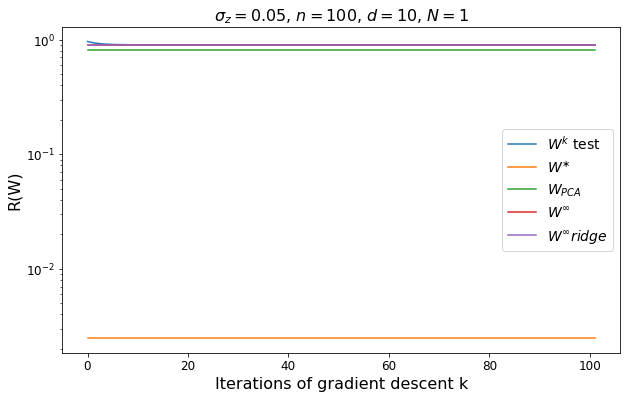



*****training size (N) = 2*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.75107467
Converged gradient descent: test risk: 0.8011432
Converged ridge gradient descent: test risk: 0.8011432
15.362778786140536
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 127 due to early stopping
Gradient descent: test risk last: 0.80114335; test risk early stopped: 0.80114317; train loss: 1.3055637512176936e-15


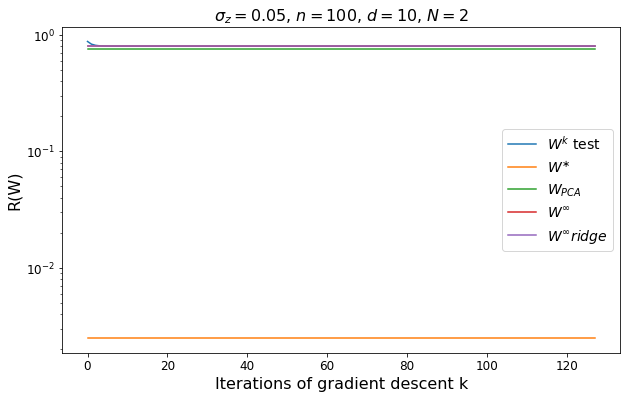



*****training size (N) = 4*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.57461347
Converged gradient descent: test risk: 0.60298801
Converged ridge gradient descent: test risk: 0.60298801
10.86312505754881
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 200 due to early stopping
Gradient descent: test risk last: 0.60298812; test risk early stopped: 0.60298806; train loss: 3.782785614966661e-15


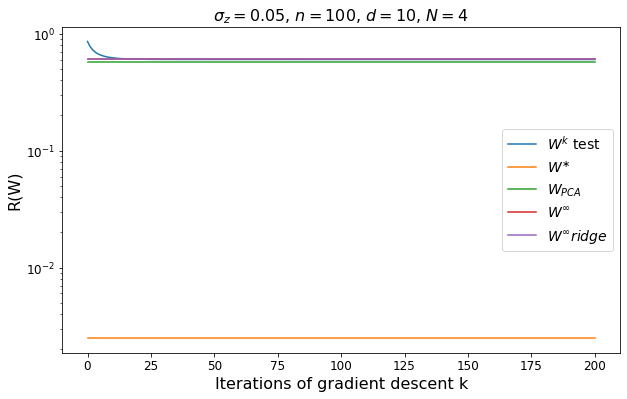



*****training size (N) = 8*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.27498679
Converged gradient descent: test risk: 0.23786471
Converged ridge gradient descent: test risk: 0.24853142
7.681389393070268
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Stopped at iteration 1516 due to early stopping
Gradient descent: test risk last: 0.23786636; test risk early stopped: 0.23786636; train loss: 4.790337397586608e-12


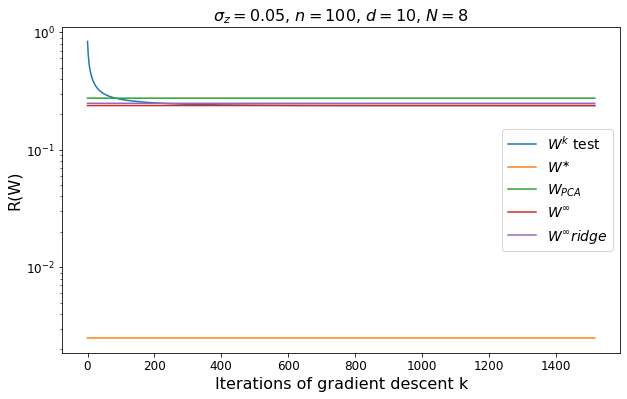



*****training size (N) = 10*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.14227203
Converged gradient descent: test risk: 0.08577271
Converged ridge gradient descent: test risk: 0.09723233
6.870443537820389
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Iteration : 1600/5000
Iteration : 1700/5000
Iteration : 1800/5000
Iteration : 1900/5000
Iteration : 2000/5000
Iteration : 2100/5000
Iteration : 2200/5000
Iteration : 2300/5000
Iteration : 2400/5000
Iteration : 2500/5000
Iteration : 2600/5000
Iteration : 2700/5000
Iteration : 2800/5000
Stopped at iteration 2877 due to early stopping
Gradient descent: test risk last: 0.08577453; test risk early stopped: 0.08577453; trai

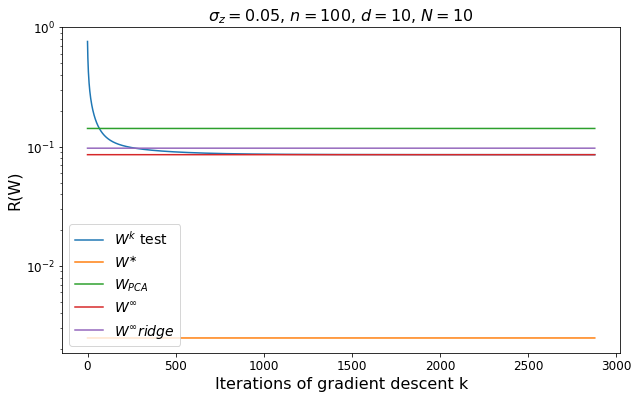



*****training size (N) = 12*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.09260151
Converged gradient descent: test risk: 0.02841483
Converged ridge gradient descent: test risk: 0.04108389
6.271828176216375
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Iteration : 1600/5000
Iteration : 1700/5000
Iteration : 1800/5000
Iteration : 1900/5000
Iteration : 2000/5000
Iteration : 2100/5000
Iteration : 2200/5000
Iteration : 2300/5000
Iteration : 2400/5000
Iteration : 2500/5000
Iteration : 2600/5000
Iteration : 2700/5000
Iteration : 2800/5000
Iteration : 2900/5000
Iteration : 3000/5000
Iteration : 3100/5000
Iteration : 3200/5000
Iteration : 3300/5000
Iteration : 3400/5000
Ite

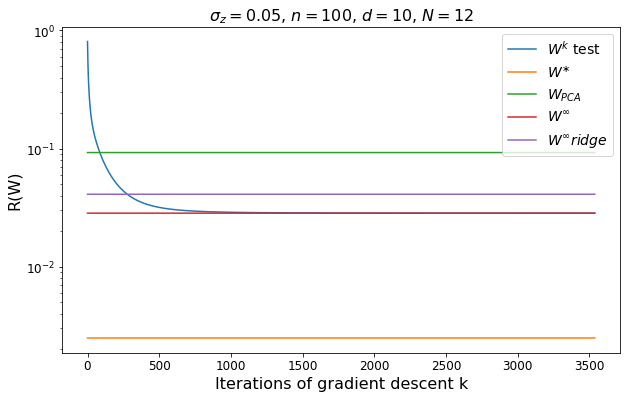



*****training size (N) = 14*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.05282487
Converged gradient descent: test risk: 0.02119099
Converged ridge gradient descent: test risk: 0.02489148
5.806584587860943
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Stopped at iteration 659 due to early stopping
Gradient descent: test risk last: 0.02058396; test risk early stopped: 0.02054629; train loss: 5.0555416237330064e-05


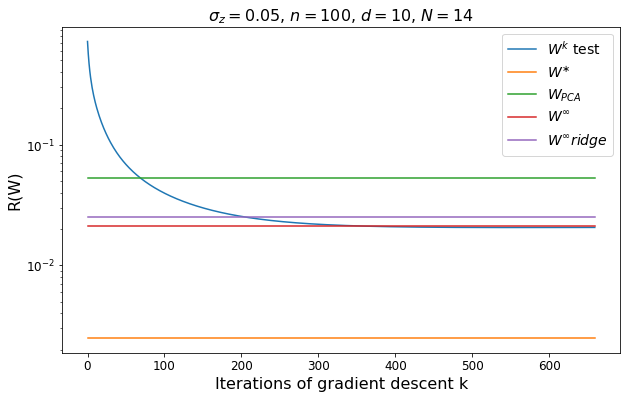



*****training size (N) = 16*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.04296021
Converged gradient descent: test risk: 0.00952431
Converged ridge gradient descent: test risk: 0.01199161
5.431562528774405
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Stopped at iteration 843 due to early stopping
Gradient descent: test risk last: 0.00943482; test risk early stopped: 0.00943261; train loss: 6.024719914421439e-05


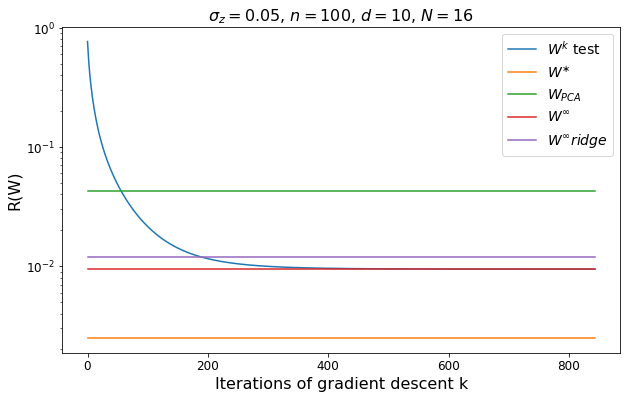



*****training size (N) = 18*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.03270187
Converged gradient descent: test risk: 0.00992313
Converged ridge gradient descent: test risk: 0.01256015
5.120926262046845
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Iteration : 1600/5000
Iteration : 1700/5000
Iteration : 1800/5000
Iteration : 1900/5000
Iteration : 2000/5000
Iteration : 2100/5000
Iteration : 2200/5000
Iteration : 2300/5000
Iteration : 2400/5000
Iteration : 2500/5000
Iteration : 2600/5000
Iteration : 2700/5000
Iteration : 2800/5000
Iteration : 2900/5000
Iteration : 3000/5000
Iteration : 3100/5000
Iteration : 3200/5000
Iteration : 3300/5000
Iteration : 3400/5000
Ite

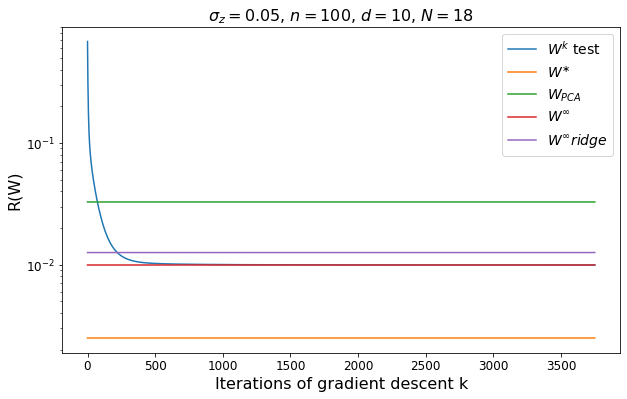



*****training size (N) = 22*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.02375412
Converged gradient descent: test risk: 0.00720068
Converged ridge gradient descent: test risk: 0.00754604
4.632052088259977
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Stopped at iteration 411 due to early stopping
Gradient descent: test risk last: 0.00658422; test risk early stopped: 0.00655409; train loss: 0.0003903054166585207


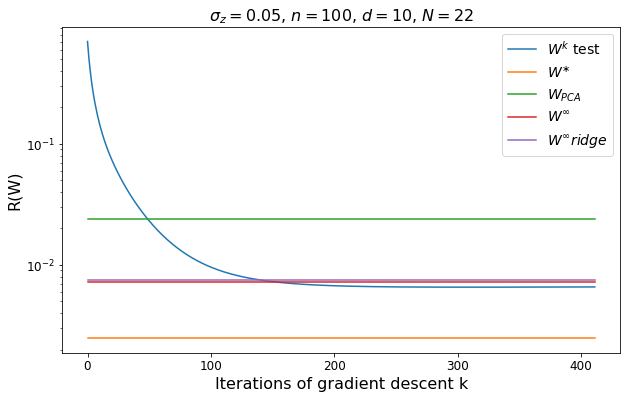



*****training size (N) = 24*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.02264816
Converged gradient descent: test risk: 0.00646469
Converged ridge gradient descent: test risk: 0.00706217
4.434852233839456
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Stopped at iteration 395 due to early stopping
Gradient descent: test risk last: 0.00602358; test risk early stopped: 0.00599956; train loss: 0.00035482857492752373


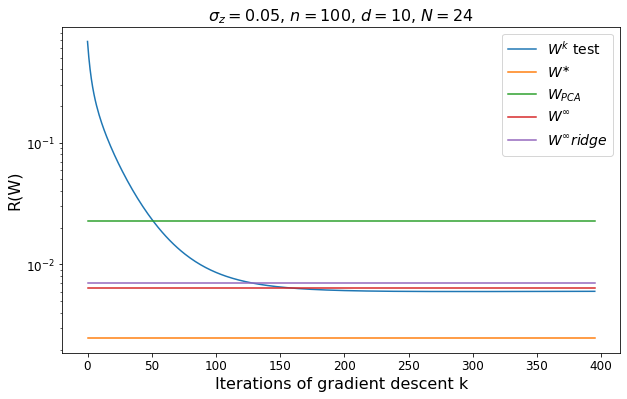



*****training size (N) = 30*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.01489781
Converged gradient descent: test risk: 0.00522747
Converged ridge gradient descent: test risk: 0.00486209
3.9666524260127263
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 257 due to early stopping
Gradient descent: test risk last: 0.00432199; test risk early stopped: 0.00428445; train loss: 0.0007797069265507162


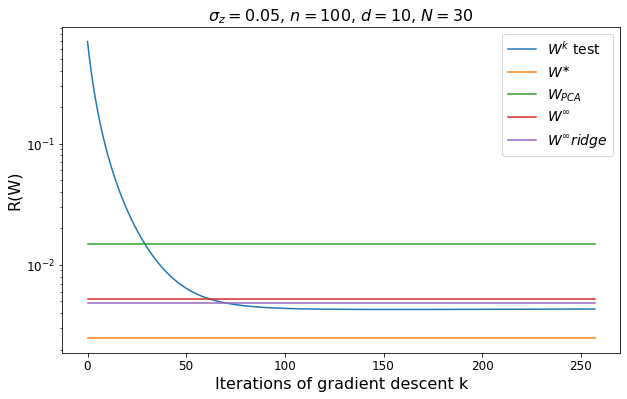



*****training size (N) = 36*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.01309754
Converged gradient descent: test risk: 0.00447618
Converged ridge gradient descent: test risk: 0.00379577
3.6210416858496033
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 228 due to early stopping
Gradient descent: test risk last: 0.00341579; test risk early stopped: 0.00338768; train loss: 0.0009370191255584359


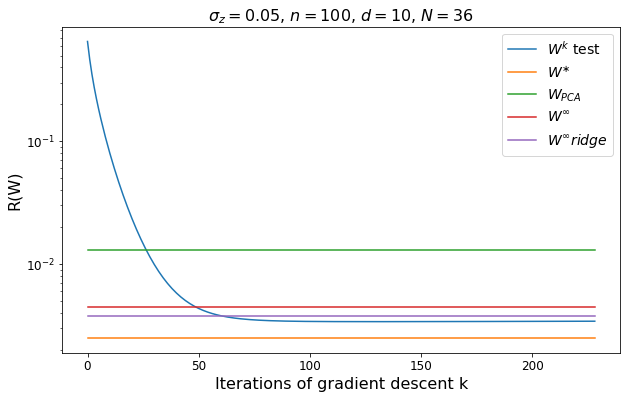



*****training size (N) = 44*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00943943
Converged gradient descent: test risk: 0.00572685
Converged ridge gradient descent: test risk: 0.00429692
3.2753554424179376
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 205 due to early stopping
Gradient descent: test risk last: 0.00373165; test risk early stopped: 0.00369963; train loss: 0.0014120583655312657


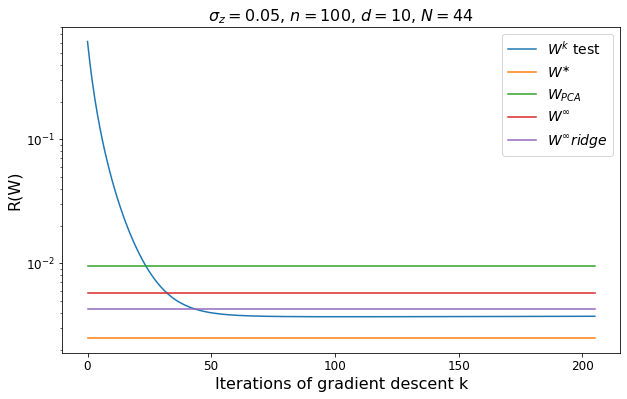



*****training size (N) = 64*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00679964
Converged gradient descent: test risk: 0.00812136
Converged ridge gradient descent: test risk: 0.00374814
2.7157812643872026
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 158 due to early stopping
Gradient descent: test risk last: 0.00292039; test risk early stopped: 0.00289004; train loss: 0.0016778603894636035


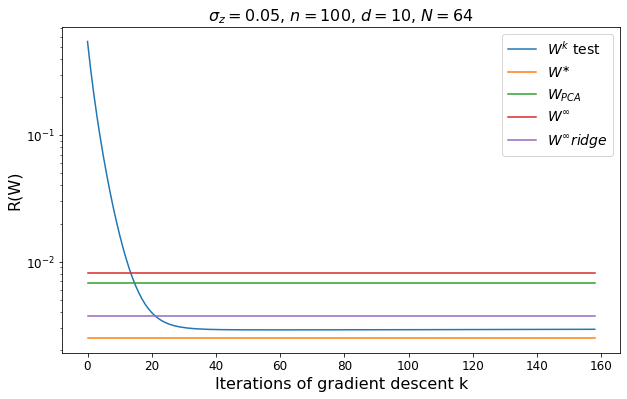



*****training size (N) = 100*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00514983
Converged gradient descent: test risk: 0.53257273
Converged ridge gradient descent: test risk: 0.00384381
2.172625011509762
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 133 due to early stopping
Gradient descent: test risk last: 0.00285065; test risk early stopped: 0.00282953; train loss: 0.0019117709016427398


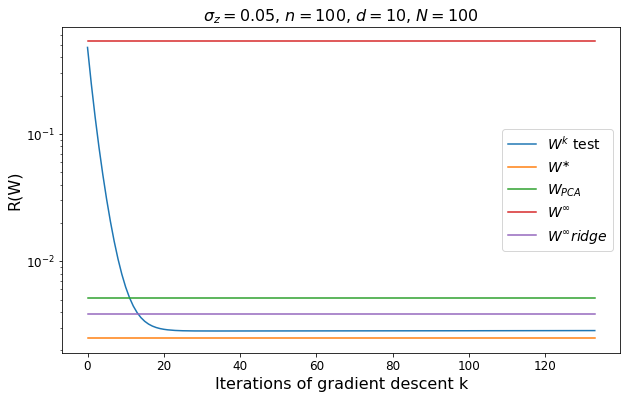



*****training size (N) = 256*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00345206
Converged gradient descent: test risk: 0.00403035
Converged ridge gradient descent: test risk: 0.00342353
1.3578906321936013
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 125 due to early stopping
Gradient descent: test risk last: 0.00261969; test risk early stopped: 0.00260748; train loss: 0.002230806741863489


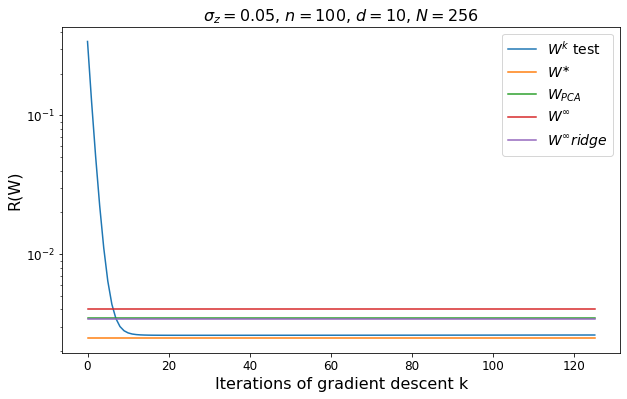



*****training size (N) = 512*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00294419
Converged gradient descent: test risk: 0.00310492
Converged ridge gradient descent: test risk: 0.00299621
0.9601736741337835
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 118 due to early stopping
Gradient descent: test risk last: 0.00255556; test risk early stopped: 0.00254781; train loss: 0.002237968845292926


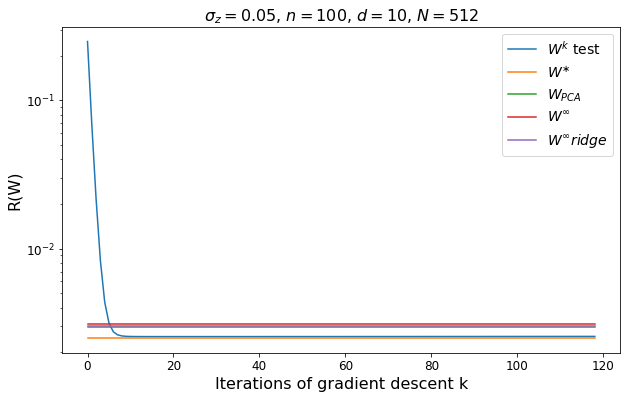



*****training size (N) = 1024*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00269658
Converged gradient descent: test risk: 0.0027679
Converged ridge gradient descent: test risk: 0.00274622
0.6789453160968006
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 113 due to early stopping
Gradient descent: test risk last: 0.00252867; test risk early stopped: 0.00252381; train loss: 0.002436843467876315


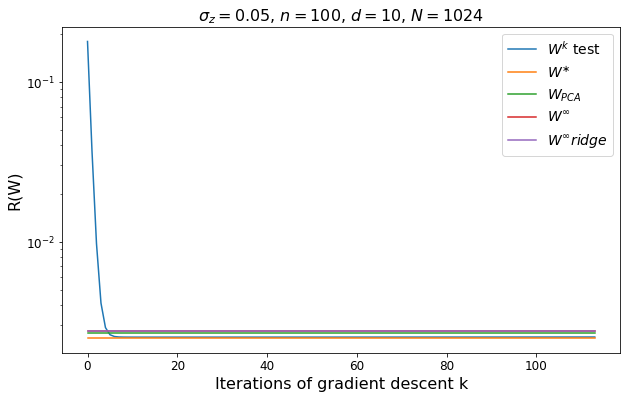



*****training size (N) = 2048*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.0025942
Converged gradient descent: test risk: 0.00262276
Converged ridge gradient descent: test risk: 0.00261793
0.48008683706689176
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 110 due to early stopping
Gradient descent: test risk last: 0.00251076; test risk early stopped: 0.00250787; train loss: 0.0024532980751246214


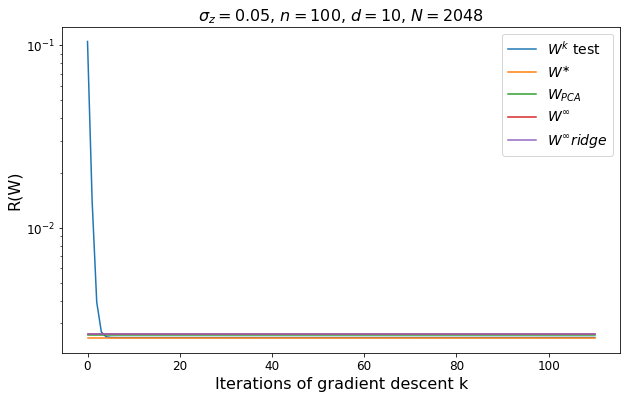



*****training size (N) = 4096*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00254281
Converged gradient descent: test risk: 0.00255291
Converged ridge gradient descent: test risk: 0.00255183
0.3394726580484003
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 108 due to early stopping
Gradient descent: test risk last: 0.00250107; test risk early stopped: 0.00249934; train loss: 0.0024700043722987175


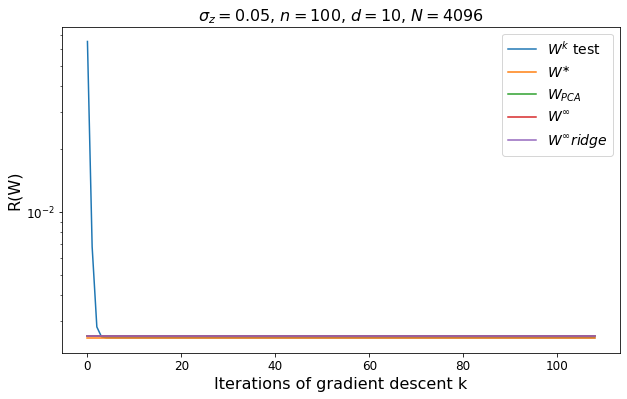



*****training size (N) = 8192*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00252136
Converged gradient descent: test risk: 0.00252422
Converged ridge gradient descent: test risk: 0.00252394
0.24004341853344588
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 106 due to early stopping
Gradient descent: test risk last: 0.00249727; test risk early stopped: 0.00249629; train loss: 0.0024682022631168365


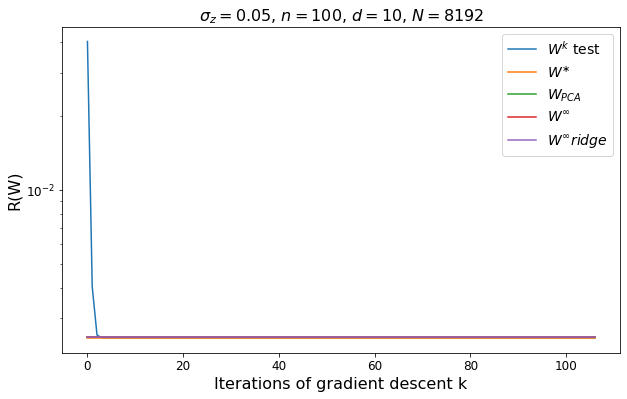



*****training size (N) = 16384*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00250715
Converged gradient descent: test risk: 0.00250883
Converged ridge gradient descent: test risk: 0.00250876
0.16973632902420016
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 106 due to early stopping
Gradient descent: test risk last: 0.00249576; test risk early stopped: 0.00249521; train loss: 0.002476808847859502


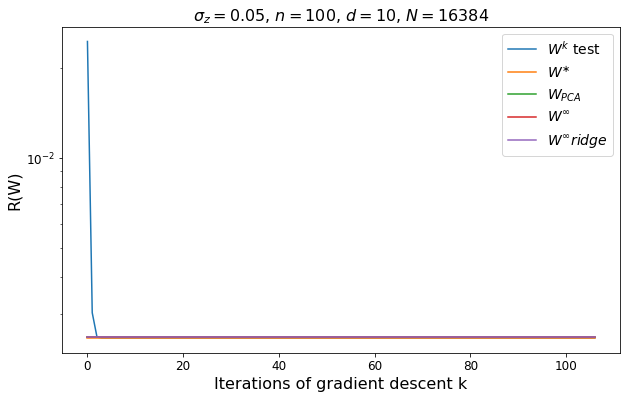



**********run 1**********
*****training size (N) = 1*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.82164005
Converged gradient descent: test risk: 0.9008717
Converged ridge gradient descent: test risk: 0.9008717
21.72625011509762
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 101 due to convergence
Gradient descent: test risk last: 0.90087175; test risk early stopped: 0.90087175; train loss: 0.0


*****training size (N) = 2*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.76534821
Converged gradient descent: test risk: 0.80127401
Converged ridge gradient descent: test risk: 0.80127401
15.362778786140536
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 141 due to early stopping
Gradient descent: test risk last: 0.80127394; test risk early stopped: 0.80127394; train loss: 5.3809169813857135e-15


*****training size (N) = 4*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.582029

In [109]:
# Store results
PCA_est_results = {'test_l':np.zeros([runs,len(train_size)])}
GDconv_results = {'test_l':np.zeros([runs,len(train_size)])}
GDconv_ridge_results = {'test_l':np.zeros([runs,len(train_size)])}
learn_results = {'test_l':{}, 'train_l_emp':{}}
opt_est_results = {'test_l':np.zeros([runs,len(train_size)])}



for r in range(runs):
    print("**********run {}**********".format(r))
    for i,N in enumerate(train_size):
        print("*****training size (N) = {}*****".format(N))
        X,Y,U = generate_data(n,d,sigma_z,N)
        
        ### optimal estimation
        W= W_star(U,sigma_z)
        teL=test_risk(n,d,W,U,sigma_z)
        opt_est_results['test_l'][r,i] = teL
        print("Optimal estimatior: test risk: {}".format(np.round(teL,precision)))


        ### PCA estimator
        W = pca_subspace(Y,d,sigma_z)  
        teL = test_risk(n,d,W,U,sigma_z)     
        PCA_est_results['test_l'][r,i] = teL
        print("PCA estimation: test risk: {}".format(np.round(teL,precision)))

        
        ### Estimator learned with gradient descent in the limit of infinite many iterations 
        W= gradient_descent_converged(X,Y)
        teL= test_risk(n,d,W,U,sigma_z)   
        GDconv_results['test_l'][r,i] = teL
        print("Converged gradient descent: test risk: {}".format(np.round(teL,precision)))

        ### Estimator learned with ridge gradient descent in the limit of infinite many iterations 
        W= gradient_descent_ridge_converged(X,Y,0.1)
        teL= test_risk(n,d,W,U,sigma_z)   
        GDconv_ridge_results['test_l'][r,i] = teL
        print("Converged ridge gradient descent: test risk: {}".format(np.round(teL,precision)))
        

        ### Estimator learned with gradient descent
        num_iters = 5000
        epsilon = np.sqrt(10* (d+sigma_z**2*n) * np.log(n) / N)
        print(epsilon)
        lr = 1/(N * (1+epsilon) * (1+sigma_z**2))
              
        testL, trainL_emp = gradient_descent_train(n ,d ,N ,X , Y, U, sigma_z, num_iters, lr)
        learn_results['test_l'][str(r)+str(i)] = testL
        learn_results['train_l_emp'][str(r)+str(i)] = trainL_emp
        risk_last = np.round(learn_results['test_l'][str(r)+str(i)][-1],precision)
        risk_early_stopped = np.round(np.min(learn_results['test_l'][str(r)+str(i)]),precision)
        train_loss = learn_results['train_l_emp'][str(r)+str(i)][-1]
        print("Gradient descent: test risk last: {}; test risk early stopped: {}; train loss: {}".format(risk_last,risk_early_stopped,train_loss))           



        if r==0:
            fontsize = 16
            fig = plt.figure(figsize=(10,6))
            alpha=0.8
            ax = fig.add_subplot(111)
            steps = len(learn_results['test_l'][str(r)+str(i)])
            #ax.plot(range(steps), learn_results['train_l_emp'][str(r)+str(i)],label=r"$W^{k}$ train")
            ax.plot(range(steps), learn_results['test_l'][str(r)+str(i)], label=r"$W^{k}$ test")
            ax.plot(range(steps), [opt_est_results['test_l'][r,i]]*steps,label=r"$W^{\ast}$")
            ax.plot(range(steps), [PCA_est_results['test_l'][r,i]]*steps,label=r"$W_{PCA}$")
            ax.plot(range(steps), [GDconv_results['test_l'][r,i]]*steps,label=r"$W^{\infty}$")
            ax.plot(range(steps), [GDconv_ridge_results['test_l'][r,i]]*steps,label=r"$W^{\infty} ridge$")
            ax.set_yscale('log')
            ax.set_title('$\sigma_z=${}, $n=${}, $d=${}, $N=${}'.format(sigma_z,n,d,N), fontsize=fontsize)
            ax.tick_params(axis='x', labelsize=fontsize-4 ) 
            ax.tick_params(axis='y', labelsize=fontsize-4 ) 
            ax.set_xlabel('Iterations of gradient descent k', fontsize=fontsize)
            ax.set_ylabel('R(W)', fontsize=fontsize)
            ax.legend(fontsize=fontsize-2)
            plt.show()

        print("\n")

In [110]:
#######
# Compute mean and std for plot
#######
# test performance of early stopped gradient descent
learn_results_ES = {'test_l':np.zeros([runs,len(train_size)])}
for r in range(runs):
    for i in range(len(train_size)):
        learn_results_ES['test_l'][r,i] = np.min(learn_results['test_l'][str(r)+str(i)])

PCA_est_M = PCA_est_results['test_l'].mean(0)
PCA_est_S = PCA_est_results['test_l'].std(0)
GDconv_est_M = GDconv_results['test_l'].mean(0)
GDconv_est_S = GDconv_results['test_l'].std(0)
GDconv_ridge_est_M = GDconv_ridge_results['test_l'].mean(0)
GDconv_ridge_est_S = GDconv_ridge_results['test_l'].std(0)
learn_results_ES_M = learn_results_ES['test_l'].mean(0)
learn_results_ES_S = learn_results_ES['test_l'].std(0)
opt_est_M = opt_est_results['test_l'].mean(0)
opt_est_S = opt_est_results['test_l'].std(0)

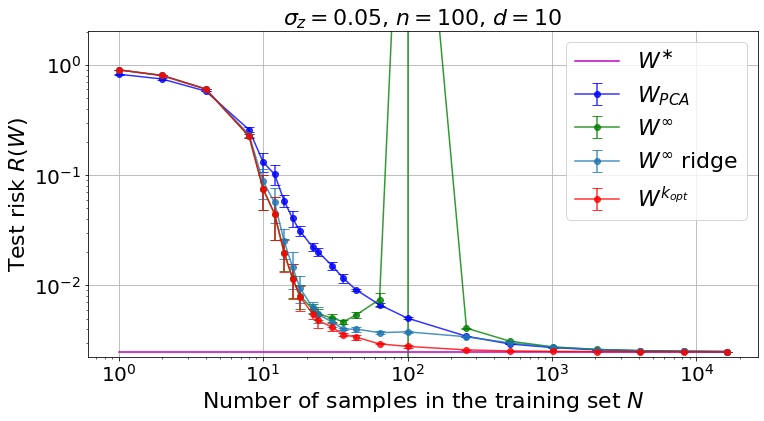

In [111]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)
ax.errorbar(train_size, PCA_est_M, yerr=PCA_est_S, color='b', fmt="-o",alpha=al,label=r"$W_{PCA}$", capsize=5)
ax.errorbar(train_size, GDconv_est_M, yerr=GDconv_est_S, color='g', fmt="-o",alpha=al,label=r"$W^{\infty}$", capsize=5)
ax.errorbar(train_size, GDconv_ridge_est_M, GDconv_ridge_est_S, fmt="-o",alpha=al,label=r"$W^{\infty}$ ridge", capsize=5)
ax.errorbar(train_size, learn_results_ES_M, yerr=learn_results_ES_S, color='r', fmt="-o",alpha=al,label=r"$W^{k_{opt}}$", capsize=5)
ax.plot(train_size, opt_est_M,color='m', label=r"$W^{\ast}$")

ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_z=${}, $n=${}, $d=${}'.format(sigma_z,n,d), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([opt_est_M[0]*0.9,2.04])

plt.grid()
plt.show()

In [112]:
GDconv_ridge_est_M

array([0.90080054, 0.8011493 , 0.60477102, 0.23298411, 0.08764327,
       0.0566821 , 0.0250666 , 0.0146429 , 0.00950767, 0.00631107,
       0.00545761, 0.00465959, 0.0040026 , 0.00401111, 0.00372467,
       0.00378832, 0.00341765, 0.003002  , 0.00274147, 0.00261933,
       0.00255428, 0.00252424, 0.00250956])

Numerical experiments with different parameters

In [11]:
def get_numerical_result_1(runs,train_size,sigma_z,n,d,precision):
   # Store results
    PCA_est_results = {'test_l':np.zeros([runs,len(train_size)])}
    GDconv_results = {'test_l':np.zeros([runs,len(train_size)])}
    GDconv_ridge_results = {'test_l':np.zeros([runs,len(train_size)])}
    learn_results = {'test_l':{}, 'train_l_emp':{}}
    opt_est_results = {'test_l':np.zeros([runs,len(train_size)])}

    for r in range(runs):
        print("**********run {}**********".format(r))
        for i,N in enumerate(train_size):
            print("*****training size (N) = {}*****".format(N))
            X,Y,U = generate_data(n,d,sigma_z,N)
            
            ### optimal estimation
            W= W_star(U,sigma_z)
            teL=test_risk(n,d,W,U,sigma_z)
            opt_est_results['test_l'][r,i] = teL

            ### PCA estimator
            W = pca_subspace(Y,d,sigma_z)  
            teL = test_risk(n,d,W,U,sigma_z)     
            PCA_est_results['test_l'][r,i] = teL
            
            ### Estimator learned with gradient descent in the limit of infinite many iterations 
            W= gradient_descent_converged(X,Y)
            teL= test_risk(n,d,W,U,sigma_z)   
            GDconv_results['test_l'][r,i] = teL

            ### Estimator learned with ridge gradient descent in the limit of infinite many iterations 
            W= gradient_descent_ridge_converged(X,Y)
            teL= test_risk(n,d,W,U,sigma_z)   
            GDconv_ridge_results['test_l'][r,i] = teL            

            ### Estimator learned with gradient descent
            num_iters = 5000
            epsilon = np.sqrt(10* (d+sigma_z**2*n) * np.log(n) / N)
            print(epsilon)
            lr = 1/(N * (1+epsilon) * (1+sigma_z**2))
                
            testL, trainL_emp = gradient_descent_train(n ,d ,N ,X , Y, U, sigma_z, num_iters, lr)
            learn_results['test_l'][str(r)+str(i)] = testL
            learn_results['train_l_emp'][str(r)+str(i)] = trainL_emp
            risk_last = np.round(learn_results['test_l'][str(r)+str(i)][-1],precision)
            risk_early_stopped = np.round(np.min(learn_results['test_l'][str(r)+str(i)]),precision)
            train_loss = learn_results['train_l_emp'][str(r)+str(i)][-1]

    # test performance of early stopped gradient descent
    learn_results_ES = {'test_l':np.zeros([runs,len(train_size)])}
    for r in range(runs):
        for i in range(len(train_size)):
            learn_results_ES['test_l'][r,i] = np.min(learn_results['test_l'][str(r)+str(i)])

    PCA_est_M = PCA_est_results['test_l'].mean(0)
    PCA_est_S = PCA_est_results['test_l'].std(0)
    GDconv_est_M = GDconv_results['test_l'].mean(0)
    GDconv_est_S = GDconv_results['test_l'].std(0)
    GDconv_ridge_est_M = GDconv_ridge_results['test_l'].mean(0)
    GDconv_ridge_est_S = GDconv_ridge_results['test_l'].std(0)
    learn_results_ES_M = learn_results_ES['test_l'].mean(0)
    learn_results_ES_S = learn_results_ES['test_l'].std(0)
    opt_est_M = opt_est_results['test_l'].mean(0)
    opt_est_S = opt_est_results['test_l'].std(0)

    param = 'n={0},d={1},sigma={2}'.format(n, d, sigma_z)
    return [PCA_est_M,PCA_est_S],[GDconv_est_M,GDconv_est_S],[GDconv_ridge_est_M,GDconv_ridge_est_S],[learn_results_ES_M,learn_results_ES_S],[opt_est_M,opt_est_S],param
      


In [12]:
fontsize = 22

Vary sigma

In [169]:
n = 100
d = 10
sigma_z = [0.01,0.05,0.1,0.15,0.2,0.3]
train_size = [1,2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256,512,1024,2048,4096,8192,16384]
runs = 5
precision = 8
fig = plt.figure(figsize=(12,6))
al = 0.8
PCA_est = [[] for i in sigma_z]
GDconv_est = [[] for i in sigma_z]
GDconv_ridge_est = [[] for i in sigma_z]
learn_results_ES = [[] for i in sigma_z]
opt_est = [[] for i in sigma_z]
param = [[] for i in sigma_z]
for i,s in enumerate(sigma_z):
    PCA_est[i], GDconv_est[i], GDconv_ridge_est[i], learn_results_ES[i], opt_est[i], param[i]=get_numerical_result_1(runs,train_size,s,n,d,precision)

**********run 0**********
*****training size (N) = 1*****
21.47038741190778
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 101 due to convergence
*****training size (N) = 2*****
15.181856533662277
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 117 due to early stopping
*****training size (N) = 4*****
10.73519370595389
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 191 due to early stopping
*****training size (N) = 8*****
7.590928266831138
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Iteration : 1600/5000
Stopped at iteration 1693 due to early stopping
*****training size (N) = 10*****
6.789532646783635
Iteration : 0/5000
Iteration : 100/5000
Iteration : 20

<Figure size 864x432 with 0 Axes>

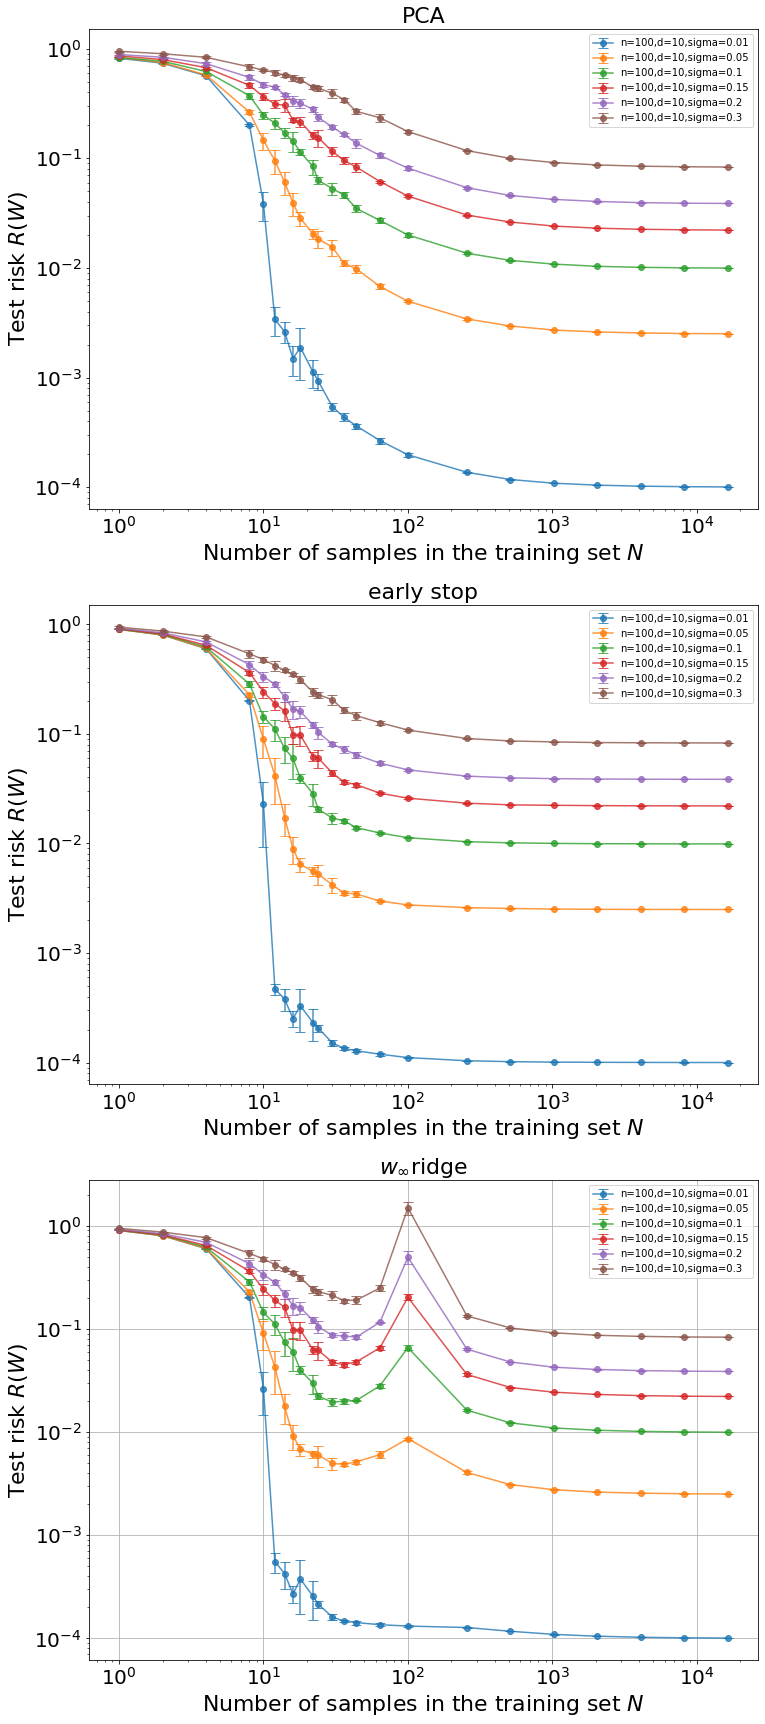

In [170]:
fig = plt.figure(figsize=(12,30))
al = 0.8
ax = fig.add_subplot(311)
for i in range(6):
    ax.errorbar(train_size, PCA_est[i][0], yerr=PCA_est[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
#ax.plot(train_size, opt_est[0],color='m', label=r"$W^{\ast}$")
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title('PCA', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est[0][0]*0.9,2.04])

ax = fig.add_subplot(312)
for i in range(6):
    ax.errorbar(train_size,learn_results_ES[i][0], yerr=learn_results_ES[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
#ax.plot(train_size, opt_est[0],color='m', label=r"$W^{\ast}$")
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title('early stop', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])

ax = fig.add_subplot(313)
for i in range(6):
    ax.errorbar(train_size, GDconv_ridge_est[i][0], yerr=GDconv_ridge_est[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
#ax.plot(train_size, opt_est[0],color='m', label=r"$W^{\ast}$")
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title(r'$w_{\infty}$'+'ridge', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])


plt.grid()
plt.show()

In [171]:
GDconv_ridge_est[2][0]

array([0.90269664, 0.81241337, 0.62153216, 0.28565026, 0.14429242,
       0.11128322, 0.07406271, 0.06018779, 0.03991894, 0.02964985,
       0.02221437, 0.01950772, 0.01991808, 0.02027022, 0.02807107,
       0.06590063, 0.01630691, 0.01228043, 0.01096667, 0.01041302,
       0.01015459, 0.01002401, 0.00996148])

Vary d

In [172]:
n = 100
d = [5,10,20,50,70,90]
sigma_z = 0.05
train_size = [1,2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256,512,1024,2048,4096,8192,16384]
runs = 5
precision = 8
fig = plt.figure(figsize=(12,6))
al = 0.8
PCA_est = [[] for i in d]
GDconv_est = [[] for i in d]
GDconv_ridge_est = [[] for i in d]
learn_results_ES = [[] for i in d]
opt_est = [[] for i in d]
param = [[] for i in d]
for i,d_ in enumerate(d):
    PCA_est[i], GDconv_est[i], GDconv_ridge_est[i], learn_results_ES[i], opt_est[i], param[i]=get_numerical_result_1(runs,train_size,sigma_z,n,d_,precision)

**********run 0**********
*****training size (N) = 1*****
15.549001085741
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 101 due to convergence
*****training size (N) = 2*****
10.994804108404452
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 165 due to early stopping
*****training size (N) = 4*****
7.7745005428705
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Stopped at iteration 729 due to early stopping
*****training size (N) = 8*****
5.497402054202226
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Stopped at iteration 1451 due to early stopping
*****training size (N) = 10

<Figure size 864x432 with 0 Axes>

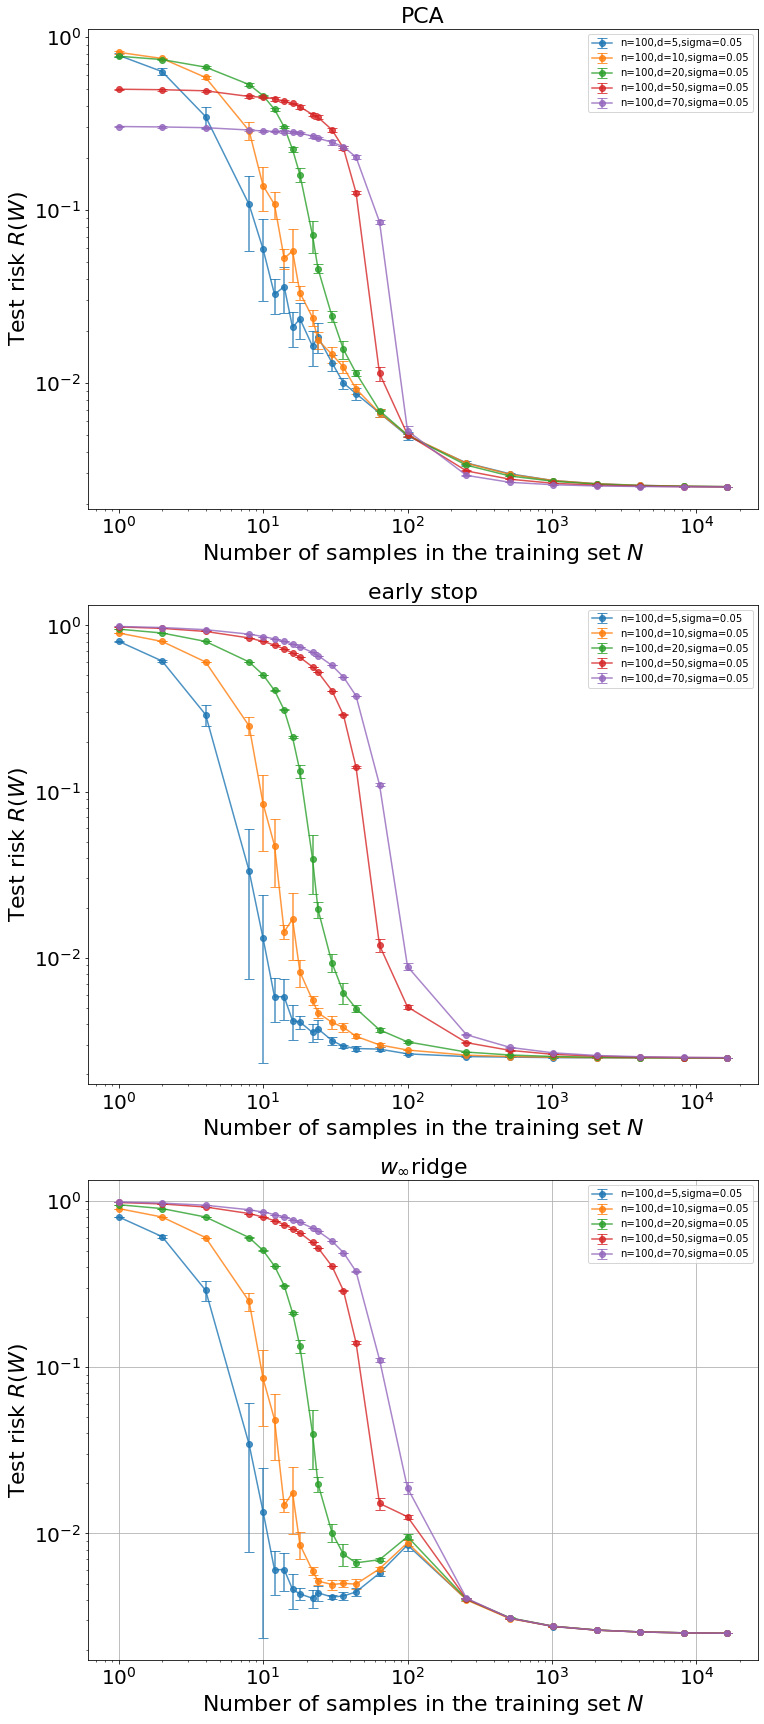

In [173]:
fig = plt.figure(figsize=(12,30))
al = 0.8
ax = fig.add_subplot(311)
for i in range(5):
    ax.errorbar(train_size, PCA_est[i][0], yerr=PCA_est[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
#ax.plot(train_size, opt_est[0],color='m', label=r"$W^{\ast}$")
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title('PCA', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est[0][0]*0.9,2.04])

ax = fig.add_subplot(312)
for i in range(5):
    ax.errorbar(train_size,learn_results_ES[i][0], yerr=learn_results_ES[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
#ax.plot(train_size, opt_est[0],color='m', label=r"$W^{\ast}$")
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title('early stop', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])

ax = fig.add_subplot(313)
for i in range(5):
    ax.errorbar(train_size, GDconv_ridge_est[i][0], yerr=GDconv_ridge_est[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title(r'$w_{\infty}$'+'ridge', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])


plt.grid()
plt.show()

Vary n

In [15]:
n = [100,256]
d = 50
sigma_z = 0.05
train_size = [1,2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256,512,1024,2048,4096,8192,16384]
runs = 2
precision = 8
fig = plt.figure(figsize=(12,6))
al = 0.8
PCA_est = [[] for i in n]
GDconv_est = [[] for i in n]
GDconv_ridge_est = [[] for i in n]
learn_results_ES = [[] for i in n]
opt_est = [[] for i in n]
param = [[] for i in n]
for i,n_ in enumerate(n):
    PCA_est[i], GDconv_est[i], GDconv_ridge_est[i], learn_results_ES[i], opt_est[i], param[i]=get_numerical_result_1(runs,train_size,sigma_z,n_,d,precision)

**********run 0**********
*****training size (N) = 1*****
48.105072689468166
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 101 due to convergence
*****training size (N) = 2*****
34.01542310819473
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 101 due to convergence
*****training size (N) = 4*****
24.052536344734083
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 107 due to convergence
*****training size (N) = 8*****
17.007711554097366
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 134 due to early stopping
*****training size (N) = 10*****
15.21215967066812
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 155 due to early stopping
*****training size (N) = 12*****
13.88673833332548
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 146 due to early stopping
*****training size (N) = 14*****
12.85662146927471
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 179 due to early stopping
*****training size

<Figure size 864x432 with 0 Axes>

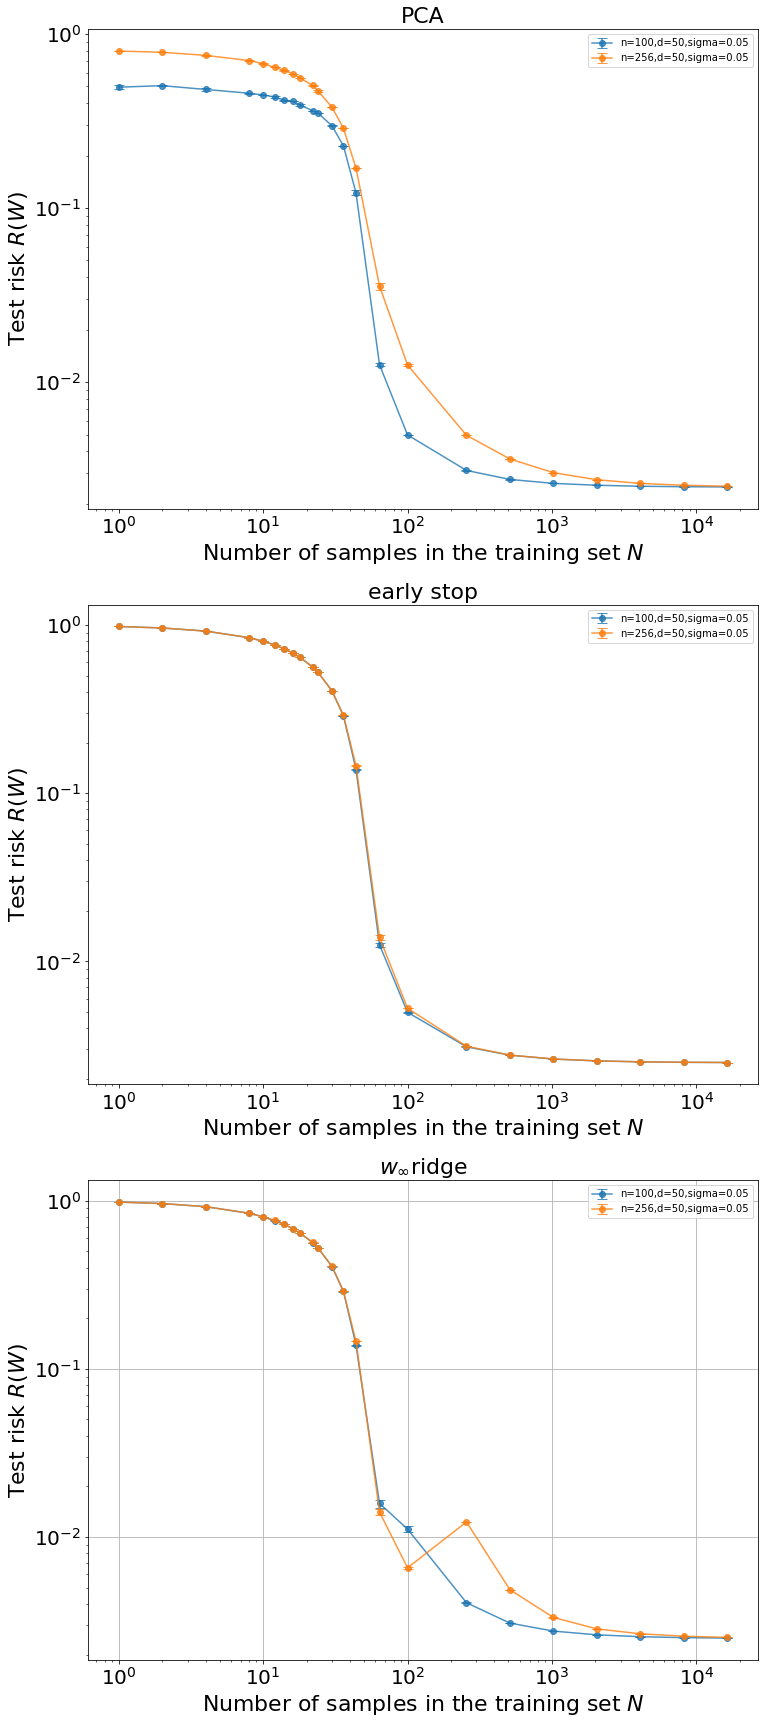

In [20]:
fig = plt.figure(figsize=(12,30))
al = 0.8
ax = fig.add_subplot(311)
for i in range(len(n)):
    ax.errorbar(train_size, PCA_est[i][0], yerr=PCA_est[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
#ax.plot(train_size, opt_est[0],color='m', label=r"$W^{\ast}$")
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title('PCA', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est[0][0]*0.9,2.04])

ax = fig.add_subplot(312)
for i in range(len(n)):
    ax.errorbar(train_size,learn_results_ES[i][0], yerr=learn_results_ES[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
#ax.plot(train_size, opt_est[0],color='m', label=r"$W^{\ast}$")
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title('early stop', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])

ax = fig.add_subplot(313)
for i in range(len(n)):
    ax.errorbar(train_size, GDconv_ridge_est[i][0], yerr=GDconv_ridge_est[i][1], fmt="-o",alpha=al,label=param[i], capsize=5)
#ax.plot(train_size, opt_est[0],color='m', label=r"$W^{\ast}$")
ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title(r'$w_{\infty}$'+'ridge', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])


plt.grid()
plt.show()

Test

In [75]:
n=100
d=10
R=1

big_sigma_squared=np.eye(d)
sigma_z=0.01

runs=10
precision = 8
train_size = [1,2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256,512,1024,2048,4096,8192,16384]
figsize=(12,30)
precision=8

al = 0.8

**********run 0**********
*****training size (N) = 1*****
*****training size (N) = 2*****
*****training size (N) = 4*****
*****training size (N) = 8*****
*****training size (N) = 10*****
*****training size (N) = 12*****
*****training size (N) = 14*****
*****training size (N) = 16*****
*****training size (N) = 18*****
*****training size (N) = 22*****
*****training size (N) = 24*****
*****training size (N) = 30*****
*****training size (N) = 36*****
*****training size (N) = 44*****
*****training size (N) = 64*****
*****training size (N) = 100*****
*****training size (N) = 256*****
*****training size (N) = 512*****
*****training size (N) = 1024*****
*****training size (N) = 2048*****
*****training size (N) = 4096*****
*****training size (N) = 8192*****
*****training size (N) = 16384*****
**********run 1**********
*****training size (N) = 1*****
*****training size (N) = 2*****
*****training size (N) = 4*****
*****training size (N) = 8*****
*****training size (N) = 10*****
*****training size

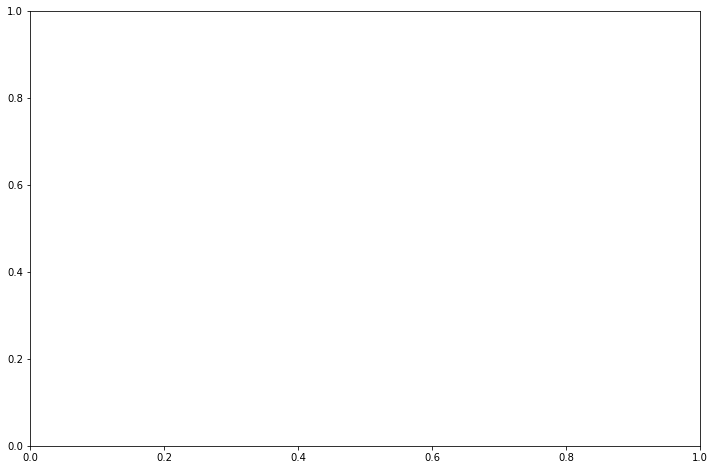

In [76]:

# Store results

GDconv_ridge_results = {'test_l':np.zeros([runs,len(train_size)])}       
for r in range(runs):
    print("**********run {}**********".format(r))
    for i,N in enumerate(train_size):
        print("*****training size (N) = {}*****".format(N))
        X,Y,U,L,mu = generate_data(R,n,d,big_sigma_squared,sigma_z,N)          
    
        ### Estimator learned with ridge gradient descent in the limit of infinite many iterations 
        W= gradient_descent_ridge_converged(X,Y,n,d,U,sigma_z,mu)
        teL= test_risk(n,d,W,U,sigma_z,mu)
        GDconv_ridge_results['test_l'][r,i] = teL.item()        
GDconv_ridge_est_M = GDconv_ridge_results['test_l'].mean(0)
GDconv_ridge_est_S = GDconv_ridge_results['test_l'].std(0)





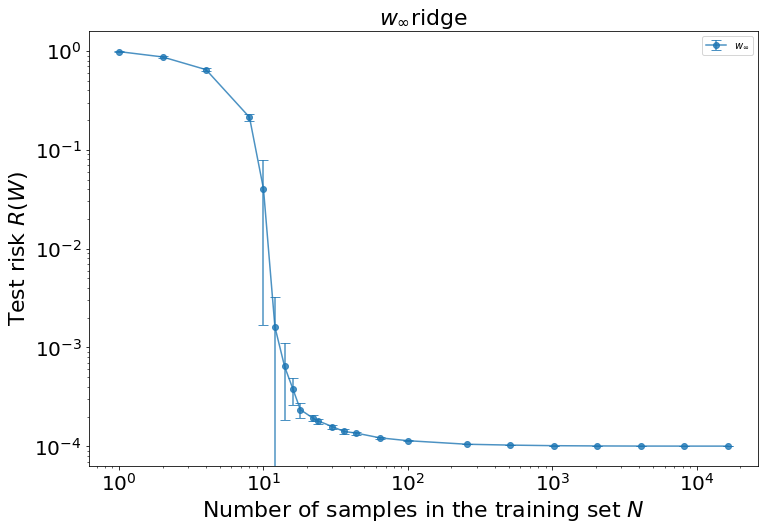

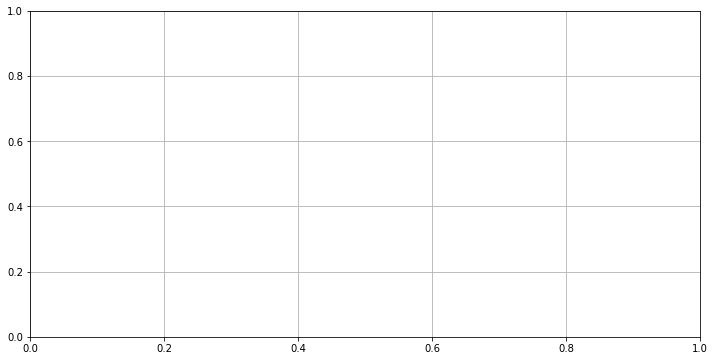

In [79]:
fig = plt.figure(figsize=(12,8))
al = 0.8
ax = fig.add_subplot(111)
fontsize = 22
fig = plt.figure(figsize=(12,6))
ax.errorbar(train_size, GDconv_ridge_est_M, yerr=GDconv_ridge_est_S, fmt="-o",alpha=al,label=r'$w_{\infty}$', capsize=5)


ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend()
ax.set_title(r'$w_{\infty}$'+'ridge', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])
plt.grid()
plt.show()